## Statistics analysis

In [ ]:
import pandas as pd
import numpy as np
import syllables as syl
from nltk.tokenize import RegexpTokenizer
from utils import *
from statistics import *

import spacy
nlp = spacy.load('de_core_news_sm')

In [ ]:
df = pd.read_csv('TextComplexityDE/TextComplexityDE19/ratings.csv', encoding='windows-1252')
custom_order = ['ID', 'Sentence', 'MOS_Complexity', 'MOS_Understandability', 'MOS_Lexical_difficulty']
cols = custom_order + list(set(df.columns.tolist()) - set(custom_order))
df = df[cols]
df

In [ ]:
df.describe()

In [ ]:
df[(df.MOS_Complexity > 6) | (df.MOS_Understandability > 6) | (df.MOS_Lexical_difficulty > 6)]

In [ ]:
from itertools import combinations

for score1, score2 in combinations(['MOS_Complexity', 'MOS_Understandability', 'MOS_Lexical_difficulty'], 2):
    print(score1, score2, np.corrcoef(df[score1], df[score2])[1,0])

In [10]:
import pandas as pd
df = pd.read_csv('public_data_text_complexity22/training_set.csv')
df.describe()

,sentence_id,MOS
count,1000.000000,1000.000000
mean,569.519000,3.015706
std,322.672914,1.180870
min,3.000000,1.000000
25%,291.750000,2.111111
50%,570.500000,3.100000
75%,850.250000,3.891667
max,1119.000000,6.333333


In [ ]:
df[df.MOS ==1]

In [ ]:
from statistics import *

In [ ]:
num_words = []
num_syls = []
avg_syls = []
word_tokens = []
for _, row in df.iterrows():
    words = tokenizer.tokenize(row.Sentence)
    word_tokens.append(words)
    num_words.append(len(words))
    syls = [syl.estimate(preprocess(word)) for word in words]
    num_syls.append(sum(syls))
    avg_syls.append(sum(syls) / len(syls))
df['num_words'] = num_words
df['num_syllables'] = num_syls
df['avg_syls_len'] = avg_syls
df['word_tokens'] = word_tokens

In [ ]:
#compare_metric = 'MOS_Complexity'
#compare_metric = 'MOS_Understandability'
compare_metric = 'MOS_Lexical_difficulty'

In [ ]:
print(df[compare_metric].corr(df['num_words']))
print(df[compare_metric].corr(df['num_syllables']))
print(df[compare_metric].corr(df['avg_syls_len']))

In [ ]:
scores = []
for _, row in df.iterrows():
    words = tokenizer.tokenize(row.Sentence)
    scores.append([wstf1(words), wstf2(words), wstf3(words), wstf4(words)])
scores = np.array(scores)
for i in range(4):
    #print(scores[:10, i], df.MOS_Complexity[:10])
    print(f"WSTF%i"%(i+1), np.corrcoef(scores[:, i], df[compare_metric])[1,0])

In [ ]:
from utils import metric_eval, scatter_preds

for  wstf_id in range(1,5):
    print(metric_eval(df[compare_metric], scores[:, wstf_id-1], classification=False))
    scatter_preds(df[compare_metric], scores[:, wstf_id-1], title=f'WSTF%i predictions'%wstf_id)

In [ ]:
for _, row in df[:10].iterrows():
    print(row.MOS_Complexity, row.MOS_Understandability, row.MOS_Lexical_difficulty)
    print((100 - fkgl(row.num_words, row.num_syllables))/14.5)

In [ ]:
s = 'Dieser Satz ist einfach'
s = 'Die Wiener Sachtextformel dient zur Berechnung der Lesbarkeit deutschsprachiger Texte. '
print(fkgl(4, 6))
print(wstf4(tokenizer.tokenize(s)))

## Torch Flesh eat

In [ ]:
from torch import nn
import torch
from torch.utils.data import Dataset, random_split, DataLoader

batch_size = 32
learning_rate = 0.1

In [ ]:
class ComplexityDataset(Dataset):

    def __init__(self, df):
        super().__init__()
        self.len = len(df)
        self.complexity = df.MOS_Complexity
        self.words = df.word_tokens
        self.syls = []
        for sample_words in self.words:
            sample_syls = np.zeros((len(sample_words)))
            for i, word in enumerate(sample_words):
                sample_syls[i] = syl.estimate(preprocess(word))
            self.syls.append(sample_syls)

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        syls = self.syls[item]
        num_words = float(len(syls))
        avg_syl_len = sum(syls) / num_words
        syl_len_3 = len(syls[syls >= 3]) / num_words
        word_len = np.array([len(w) for w in self.words])
        words_len_6 = len(word_len[word_len > 6]) / num_words
        return avg_syl_len, syl_len_3, num_words, words_len_6, float(self.complexity[item])

data = ComplexityDataset(df)

In [ ]:
num_samples = len(data)
num_train = int(num_samples * .9)
split_train, split_test = random_split(data, [num_train, num_samples - num_train])
train_dataloader = DataLoader(split_train, batch_size=batch_size)
test_dataloader = DataLoader(split_test, batch_size=batch_size)

In [ ]:
class FKGL(nn.Module):

    def __init__(self, num_vals, batch_size=batch_size):
        super().__init__()
        self.base = nn.Parameter(torch.Tensor(batch_size))
        #self.word_weight = nn.Parameter(torch.Tensor(1))
        #self.syl_weight= nn.Parameter(torch.Tensor(1))
        self.weights = nn.Parameter(torch.Tensor(num_vals).float())

    def forward(self, x):
        #tmp = torch.mul(self.word_weight, num_words)
        #tmp2 = torch.mul(self.syl_weight, avg_syls)
        #return torch.sub(torch.sub(self.base, tmp), tmp2)
        print(x.shape, x.type(), self.weights.type())
        tmp = torch.matmul(x,self.weights)
        print(tmp.shape)
        return torch.add(tmp, self.base)
#model = FKGL(num_vals=4)
model = nn.Linear(4, 1)

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def evaluate(dataloader, verbose=False):
    model.eval()

    with torch.no_grad():
        for idx, sample in enumerate(dataloader):
            label = sample[-1]
            input = sample[:-1]
            predicted_label = model(torch.stack(input).reshape((-1, 4)).float()).flatten()
            loss = criterion(predicted_label, label)
            if verbose:
                for l, p in zip(label, predicted_label):
                    print(l, p)
    return loss
print(evaluate(test_dataloader))

In [ ]:
model.train()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        labels = data[-1].float()
        input = data[:-1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(torch.stack(input).reshape((-1, 4)).float()).flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
evaluate(test_dataloader, verbose=True)

In [ ]:
model.weight

## Regression with TFIDF

In [ ]:
from datasets import load_dataset

wiki_de = load_dataset('wikipedia', '20220301.de')['train']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(wiki_de['text'])

In [ ]:
df = pd.read_csv('TextComplexityDE/TextComplexityDE19/ratings.csv', encoding='windows-1252')
df['MOS_Complexity'] = df.MOS_Complexity.apply(lambda x: int(x))
df.MOS_Complexity.value_counts()

In [ ]:
import pickle
dump = False

if dump:
    with open('models/wiki_tfidf.pkl', 'wb') as vec_out:
        pickle.dump(vectorizer, vec_out)
else:
    with open('models/wiki_tfidf.pkl', 'rb') as tfidf_in:
        vectorizer = pickle.load(tfidf_in)

In [1]:
#import torch
#from transformers import AutoTokenizer

base_model_string = "distilbert-base-german-cased"
#training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set.csv'
training_data_path = 'public_data_text_complexity22/training_set_balanced.csv'
training_feature_path = 'public_data_text_complexity22/training_set_balanced_distilbert_final.npy'
#target_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv'
target_data_path = 'public_data_text_complexity22/validation_set.csv'
target_feature_path = 'public_data_text_complexity22/validation_set_distilbert_final.npy'
#tokenizer = AutoTokenizer.from_pretrained(base_model_string)
#lm_model = torch.load('/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_trainer.pt')
final_data_path = 'public_data_text_complexity22/part2_public.csv'
final_feature_path = 'public_data_text_complexity22/final_set_distilbert_final.npy'

In [2]:
from scipy import sparse
import pandas as pd
from sklearn.model_selection import train_test_split
from text_statistics import calculate_statistics

classification = False
sentence_column = 'Sentence'
mos_column = 'MOS'

def load_and_calc_statistics(df_path, sentence_column='Sentence', mos_column='MOS', balance=None, has_labels=True):
    df = pd.read_csv(df_path)
    if classification:
        df[mos_column] = df[mos_column].apply(lambda x: int(x))
    df_balanced = balance(df, balance, mos_column) if balance else df
    X = df_balanced[sentence_column]
    y = df_balanced[mos_column].tolist() if has_labels else None

    statistics = calculate_statistics(df_balanced, sentence_column)
    statistics = sparse.hstack(list(statistics.values()))
    return X, y, statistics, df

X_train, y_train, stat_scores_train, X_train_df = load_and_calc_statistics(training_data_path)
X_val, _, stat_scores_val, df_val = load_and_calc_statistics(target_data_path, has_labels=False)
X_final, _, stat_scores_final, df_final = load_and_calc_statistics(final_data_path, has_labels=False)

In [6]:
X_train_tmp = X_train.copy()
y_train_tmp = y_train.copy()
X_val_tmp = X_val.copy()
X_final_tmp = X_final.copy()

In [14]:
X_train = X_train_tmp.copy()
y_train = y_train_tmp.copy()
X_val = X_val_tmp.copy()
X_final = X_final_tmp.copy()

In [3]:
# include text in training
import numpy as np
from sklearn.decomposition import TruncatedSVD

neural_embedding = True
only_statistics = False
pca_dim = -1 # -1 for no projection

if only_statistics:
    X_train_vec, X_test_vec, y_train, y_test = train_test_split(stat_scores_train, y_train, test_size=0.05, shuffle=True)
    X_val_vec = stat_scores_val
    X_final_vec = stat_scores_final
    print(X_train_vec.shape)
    embedding_dim = 0
else:
    if neural_embedding:
      print('Load distilbert features')
      X_train_vec = np.load(training_feature_path)[:, 0, :]
      X_train_vec, X_test_vec, y_train, y_test, scores_train, scores_test = train_test_split(X_train_vec, y_train, stat_scores_train, test_size=0.05, shuffle=True)
      X_val_vec = np.load(target_feature_path)[:, 0, :]
      X_final_vec = np.load(final_feature_path)[:, 0, :]
    else:
      X_train, X_test, y_train, y_test, scores_train, scores_test = train_test_split(X_train, y_train, stat_scores_train, test_size=0.05, shuffle=True)
      print('Vectorize')
      X_test_vec = vectorizer.transform(X_test)
      X_train_vec = vectorizer.transform(X_train)
      X_val_vec = vectorizer.transform(X_val)
      X_final_vec = vectorizer.transform(X_final)

    embedding_dim = X_train_vec.shape[1]

    if pca_dim != -1:
        print('Reducing dimensionality')
        pca_transformer = TruncatedSVD(pca_dim)
        X_train_vec = pca_transformer.fit_transform(X_train_vec)
        X_test_vec = pca_transformer.transform(X_test_vec)
        X_val_vec = pca_transformer.transform(X_val_vec)
        X_final_vec = pca_transformer.transform(X_final_vec)
        embedding_dim = pca_dim

    print('Concat with statistics')
    print(X_train_vec.shape)
    print(scores_train.shape)
    X_train_vec = sparse.hstack([X_train_vec, scores_train])
    print(X_train_vec.shape)
    X_test_vec = sparse.hstack([X_test_vec, scores_test])
    X_val_vec = sparse.hstack([X_val_vec, stat_scores_val])
    X_final_vec = sparse.hstack([X_final_vec, stat_scores_final])

Load distilbert features
Concat with statistics
(1001, 768)
(1001, 12)
(1001, 780)


In [4]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils.class_weight import compute_class_weight

#clf = LinearRegression()
#clf = LogisticRegression()
if classification:
    classes = sorted(np.unique(y_train))
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    weights = {i: weights[i-1] for i in classes}
    #weights = {1: 0.8284313725490197, 2: 0.6343843843843844, 3: 0.5501302083333334, 4: 0.9265350877192983, 5: 3.434959349593496, 6: 3500.208333333333336}
clf = SVR()
#clf = KernelRidge(alpha=5.0)
clf.fit(X_train_vec, y_train)

SVR()

In [5]:
import joblib
clf = joblib.load('models/svr_distil_statistics_final.pkl')
#clf = joblib.load('models/statistics_svr.pkl')

Train: 0.4029778964169217
0.40168847847523564


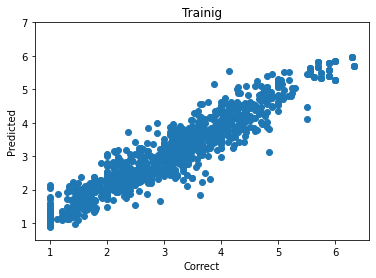

Test 0.4016825612795266
0.39764724633290743


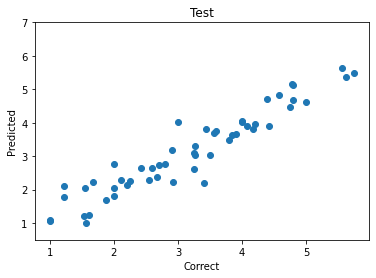

In [5]:
from utils import metric_eval, scatter_preds, rmse_mapped_direct

y_pred_test = clf.predict(X_test_vec)
y_pred_train = clf.predict(X_train_vec)
print('Train:', metric_eval(y_train, y_pred_train, classification))
print(rmse_mapped_direct(y_train, y_pred_train))
scatter_preds(y_train, y_pred_train, 'Trainig')
print('Test', metric_eval(y_test, y_pred_test, classification))
print(rmse_mapped_direct(y_test, y_pred_test))
scatter_preds(y_test, y_pred_test, 'Test')

In [10]:
def rmse_mapped_direct_tmp(y_true, y_pred, deg):
    coef = np.polyfit(y_pred, y_true, deg)
    mapping = np.poly1d(coef)

    y_mapped = mapping(y_pred)
    return metric_eval(y_true, y_mapped, classification=False)

print(rmse_mapped_direct_tmp(y_train, y_pred_train, 1), rmse_mapped_direct_tmp(y_train, y_pred_train, 3))
print(rmse_mapped_direct_tmp(y_test, y_pred_test, 1), rmse_mapped_direct_tmp(y_test, y_pred_test, 3))

0.4040945084802731 0.4031659446052431
0.3867593929343621 0.38563431318385427


In [75]:
from utils import write_answer_file
y_pred_val = clf.predict(X_val_vec)
write_answer_file(df_val, y_pred_val)

In [8]:
y_pred_val[y_pred_val < 1]

array([], dtype=float64)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

def plot_permutation_score(features, perm_importance, save_fig=False):
    sorted_idx = perm_importance.importances_mean.argsort()
    sorted_idx = sorted_idx[-max_features:] if max_features < sorted_idx.shape[0] else sorted_idx
    sorted_pos = sorted_idx[perm_importance.importances_mean[sorted_idx] > 0]
    sorted_neg = sorted_idx[perm_importance.importances_mean[sorted_idx] <= 0]
    print(sorted_idx, sorted_pos, sorted_neg)
    #plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], height=0.5)
    plt.barh(features[sorted_neg], perm_importance.importances_mean[sorted_neg], height=0.5, color='r')
    plt.barh(features[sorted_pos], perm_importance.importances_mean[sorted_pos], height=0.5)
    plt.xlabel("Permutation Importance")
    plt.ylabel('feature')
    if save_fig:
        plt.savefig('svr_statistics.pdf', bbox_inches='tight')

max_features = 20
features_names = [f'distil_%i'%i for i in range(embedding_dim)] + \
                 ['mtd', 'pc3', 'asl', 'pw6', 'ps1', 'asc', 'wstf1', 'wstf2', 'wstf3', 'wstf4', 'fre_amstad', 'SMOG']
#                 ['tree_depth', 'perc_syl_3', 'avg_sent_len', 'perc_word_6', 'perc_syl_1', 'avg_syl_count',
#                  'wstf1', 'wstf2', 'wstf3', 'wstf4', 'fre_amstad', 'SMOG']
features = np.array(features_names)
perm_importance = permutation_importance(clf, X_test_vec.toarray(), y_test)
print(len(features), perm_importance.importances_mean, X_test_vec.shape)
plot_permutation_score(features, perm_importance)

[ 1  5  4  3  6  7 11  8  9  0 10  2] [ 1  5  4  3  6  7 11  8  9  0 10  2] []


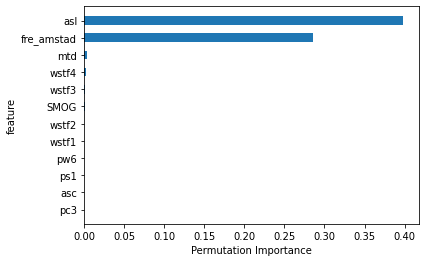

In [19]:
plot_permutation_score(features, perm_importance, save_fig=True)

In [9]:
import joblib
joblib.dump(clf, 'models/svr_distil_statistics_final.pkl')

['models/svr_distil_statistics_final.pkl']

In [33]:
y_pred_final = clf.predict(X_final_vec)
answer = pd.DataFrame()
answer['ID'] = df_final.ID
answer['MOS'] = y_pred_final

answer.to_csv('svr_final.csv', index=False)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

features_names = ['tree_depth', 'perc_syl_3', 'avg_sent_len', 'perc_word_6', 'perc_syl_1', 'avg_syl_count',
                  'wstf1', 'wstf2', 'wstf3', 'wstf4', 'fre_amstad', 'SMOG']
features = np.array(features_names)
perm_importance = permutation_importance(clf, X_test_vec.toarray(), y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

## PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD

tfidfs = vectorizer.transform(X)
pca_transformer = TruncatedSVD(1)
projected = pca_transformer.fit_transform(X_train_vec)

ValueError: x and y arrays must be equal in length along interpolation axis.

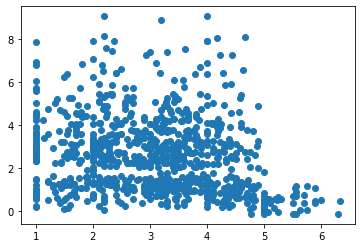

In [ ]:
from utils import scatter_preds
scatter_preds(y_train, projected)

## Explain distil_149

In [27]:
X_train, y_train, stat_scores_train, X_train_df = load_and_calc_statistics(training_data_path)
X_train_vec = np.load(training_feature_path)[:, 0, :]

In [ ]:
X_train_df

In [155]:
max_vals = list(X_train_vec[:, 149].argsort()[-10:])
print(max_vals)
df_max_vals = X_train_df.iloc[max_vals]
df_max_vals['distil_149'] = X_train_vec[:, 149][max_vals]
df_max_vals

[378, 433, 524, 859, 157, 835, 451, 11, 278, 87]


C:\Users\Miriam\AppData\Local\Temp\ipykernel_3696\100626086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_vals['distil_149'] = X_train_vec[:, 149][max_vals]


,sentence_id,Sentence,MOS,distil_149
378,434,Gemeint ist damit ein längerfristiger Massenve...,5.555556,-2.710276
433,493,Während die Historische Klimatologie vielfach ...,5.555556,-2.668970
524,596,Das Erscheinungsbild des Nationalparks prägen ...,5.555556,-2.541231
859,972,Die Vorbereitungen zur endlichen Verwirklichun...,5.625000,-2.175321
157,188,"Er konstruierte ein Gerät, das die Schallwelle...",5.700000,-2.165929
835,947,Nach dieser Eingliederung in das ordentliche G...,5.555556,-2.060754
451,517,Der Kohlenstoff wurde dem normalen Kreislauf e...,6.000000,-1.894582
11,15,Zudem erfolgt im Laufe des Auslaufprozesses ei...,5.700000,-1.498638
278,324,Die Pluralisierung der Familienformen mit zune...,5.888889,-1.383081
87,105,Werden diese Versorgungsbahnen durch ein Aufli...,6.300000,-1.316412


In [143]:
print(np.corrcoef(X_train_vec.toarray()[:, 149], y_train))
np.corrcoef(X_train_vec.toarray()[:, 148], y_train)

[[1.         0.90075685]
 [0.90075685 1.        ]]


array([[ 1.        , -0.52424695],
       [-0.52424695,  1.        ]])

## SHAP explain SVR

In [12]:
import joblib
clf = joblib.load('models/svr_distil_statistics_final.pkl')

In [13]:
import shap
explainer = shap.KernelExplainer(clf.predict, X_test_vec)

In [ ]:
shap_values = explainer.shap_values(X_test_vec.tocsr()[:10])
#shap.force_plot(explainer.expected_value, shap_values, X_test_vec.toarray())

In [11]:
#joblib.dump(shap_values, 'svr_distil_explained.pkl')
shap_values = joblib.load('svr_distil_explained.pkl')

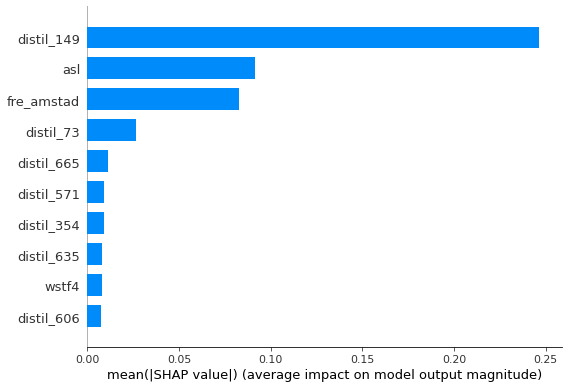

In [18]:
features_names = [f'distil_%i'%i for i in range(embedding_dim)] + \
                 ['mtd', 'pc3', 'asl', 'pw6', 'ps1', 'asc', 'wstf1', 'wstf2', 'wstf3', 'wstf4', 'fre_amstad', 'SMOG']
shap.summary_plot(shap_values, X_test_vec, feature_names=features_names, plot_type='bar', max_display=10)
#shap.summary_plot(shap_values, X_test_vec, feature_names=features_names, plot_type='bar', show=False,  max_display=10)
#plt.savefig('svr_distil_shap.pdf')

In [70]:
def find_sent_for_scores(i):
    explained_scores = X_test_vec[i].toarray()[0]
    return X_train[(stat_scores_train.toarray() ==explained_scores).all(axis=1)].values

['Während extreme Kälteereignisse seltener auftreten, werden außergewöhnliche Hitzeereignisse wahrscheinlicher.'] 2.8


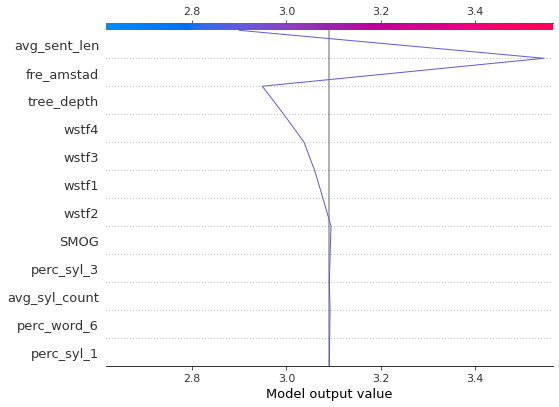

In [74]:
print(find_sent_for_scores(0), y_test[0])
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names =list(features_names))

In [86]:
from shap import initjs
initjs()

i = 26
print(find_sent_for_scores(i), y_test[i])
shap.force_plot(explainer.expected_value, shap_values[i], X_test_vec[i].toarray(), feature_names=features_names)

['Dies spiegelt sich zum Beispiel in der Redewendung „Der Traum zerplatzte wie eine Seifenblase“ oder im Synonym ,Seifenblasenwirtschaft‘ für Bubble Economy.'] 3.3


In [73]:
from text_statistics import fre_amstad, analyse_general_statistics

tmp = analyse_general_statistics('Während extreme Kälteereignisse seltener auftreten, werden außergewöhnliche Hitzeereignisse wahrscheinlicher.'.split(' '))
fre_amstad(tmp)

-43.5